![alt text](../img/general/header.png)

## High-Level Synthesis for Machine Learning (hls4ml)


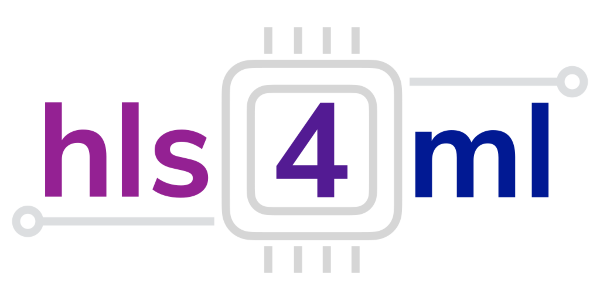

💡 **High-Level Synthesis for Machine Learning (hls4ml)** es una biblioteca de código abierto diseñada para convertir modelos de aprendizaje automático en descripciones de hardware optimizadas para su implementación en FPGAs 

**Características de hls4ml:** 

- Convierte modelos de Keras, TensorFlow, PyTorch, y ONNX en proyectos HLS (High-Level Synthesis).

- Usa herramientas como Xilinx Vitis HLS y Intel HLS Compiler para generar código en C++ optimizado para hardware.

- Permite reducir la latencia y el consumo de energía, mejorando la eficiencia en implementaciones de IA en edge computing.

- Soporta técnicas de cuantización y pruning para reducir el tamaño del modelo sin afectar significativamente su precisión.

**Aplicaciones de hls4ml:**

- Procesamiento en tiempo real en sistemas embebidos.

- Implementación de redes neuronales en hardware de baja potencia.

- Aceleración de modelos de IA en aplicaciones como física de partículas, visión artificial y robótica.


Para más información:

- GitHub: https://github.com/fastmachinelearning/hls4ml

- Web site: https://fastmachinelearning.org/hls4ml/

---

### Librerías

In [ ]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
import hls4ml
import matplotlib.pyplot as plt


### Path a Vitis HLS


Como paso inicial se debe especificar el directorio de instalación de Vivado HLS o Vitis HLS. 

In [ ]:
# Path donde se encuentra instalado Vitis HLS!! 

os.environ['PATH'] = '/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:' + os.environ['PATH']

# Para MÁQUINA VIRTUAL!
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2022.2/bin:' + os.environ['PATH']
os.environ['PATH']



### Carga del modelo (.h5)

Carga del modelo pre-entrenado y guardado en formato **.h5**. 

Para este laboratorio, el modelo fue generado en el **lab03**.

In [ ]:

from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)

model = load_model('model/mnistQAP-1-9-binary.h5', custom_objects=co)

# Resumen del modelo
model.summary()


In [ ]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=60, color='green', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Model MLP for MNIST - Weight Distribution")
plt.show()


### hls4ml 

💡 Arbitrary precision reference: https://docs.amd.com/r/2022.2-English/ug1399-vitis-hls/Fixed-Point-Identifier-Summary?tocId=jgeN4rPFF_M6nxbDn1H5HA

In [ ]:

hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

import plotting

print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")




In [ ]:
from hls4ml.model.profiling import numerical, get_ymodel_keras

# the name of the different layers could be different!! 

hls_config['LayerName']['fc1_input_input']['Precision'] = 'ap_fixed<16, 6>'  
hls_config['LayerName']['fc1_input']['Precision'] = 'ap_fixed<8, 2>'  

hls_config['LayerName']['relu_input']['Precision'] = 'ap_fixed<8, 3>'
hls_config['LayerName']['sigmoid']['Strategy'] = 'Stable'

hls_config['Model']['Precision'] = 'ap_fixed<16,6>'



### hls4ml con Vitis HLS como backend

In [ ]:
cfg = hls4ml.converters.create_config(backend='Vitis')

# cfg['IOType']     = 'io_stream'   # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config      # HLS configuraiton
cfg['KerasModel'] = model           # Keras model to be converted
cfg['OutputDir']  = 'hlsPrj/student_qap_final'       # Project name
cfg['Part'] = 'xc7z020clg484-1'     # PYNQ-Z1 or Zedboard: xc7z020clg484-1  ARTIX-7 xc7a35tcsg325-1  # MPSoC xczu4eg-sfvc784-2-e  xczu3eg-sfvc784-1-e


hls_model = hls4ml.converters.keras_to_hls(cfg)

hls_model.compile()

In [ ]:
hls_model.build(csim=False, export=False)

----

#### 📝 Ejercicio

- Realizar el proceso de síntesis para distintos modelos con diferentes técnicas de compresión y efectuar una comparación de los resultados obtenidos (latencia y utilización de recursos). ¿Qué conclusiones puede sacar al vincular el hardware generado con la técnica de compresión empleada? Considerar MNIST o Fashion dataset, empleando MLP como arquitectura (sin _flatten_ en la primera capa). Considere:
    
    - Pruning + quantization ( 8 bits)
    
    - Quantization (16 bits)

    - Knowledge distillation 
